In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import model_selection
from scrape import get_teams

#to ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
#conn = sqlcmds.create_connection('nhl-stats.sqlite3')
engine = sqlalchemy.create_engine('sqlite:///nhl-stats.sqlite3')
conn = engine.connect()

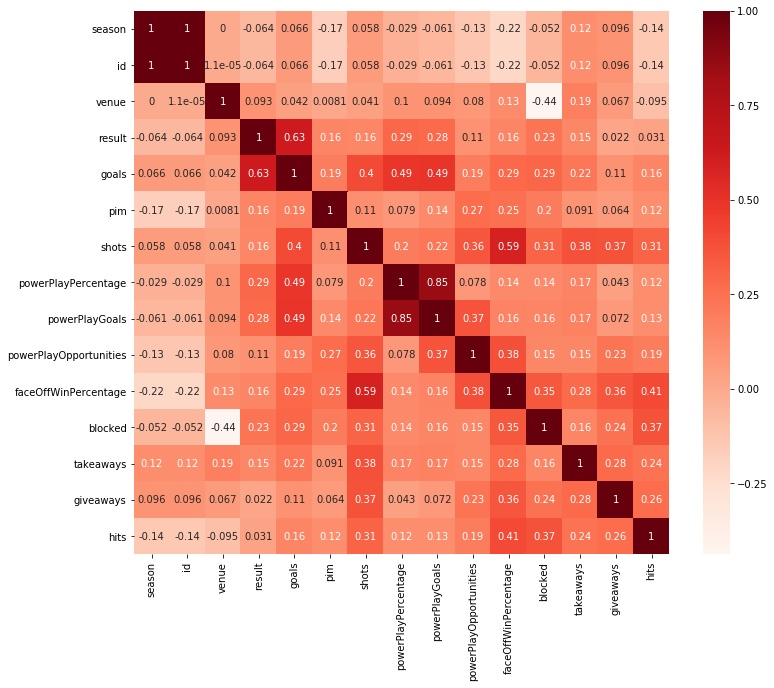

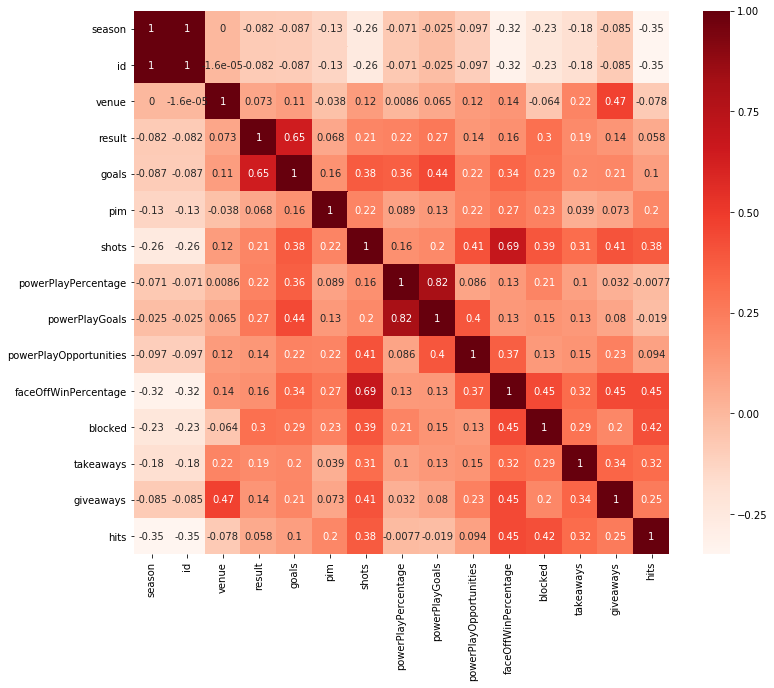

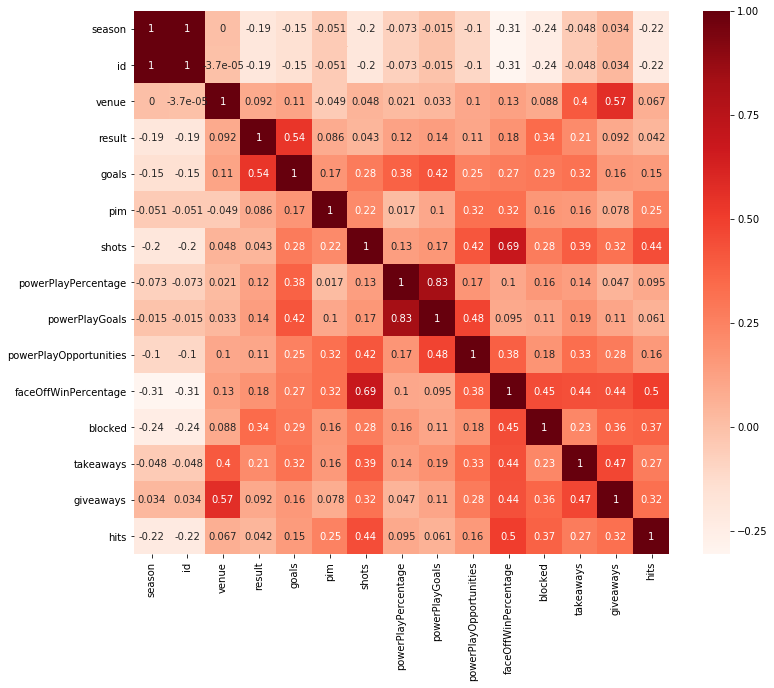

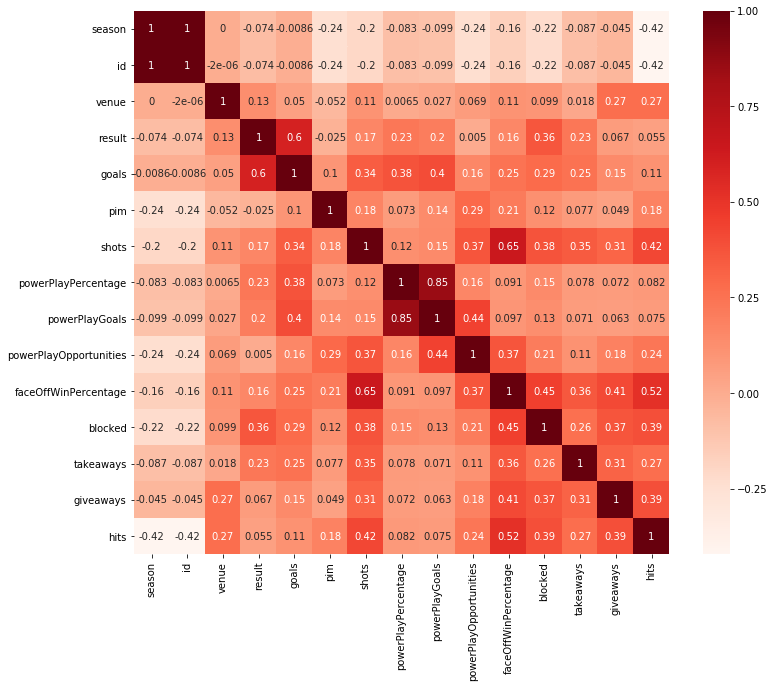

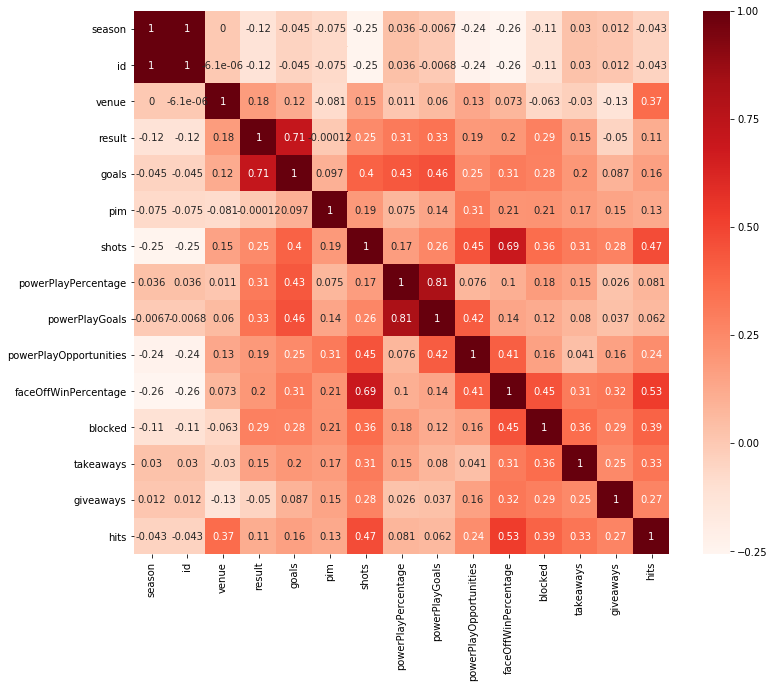

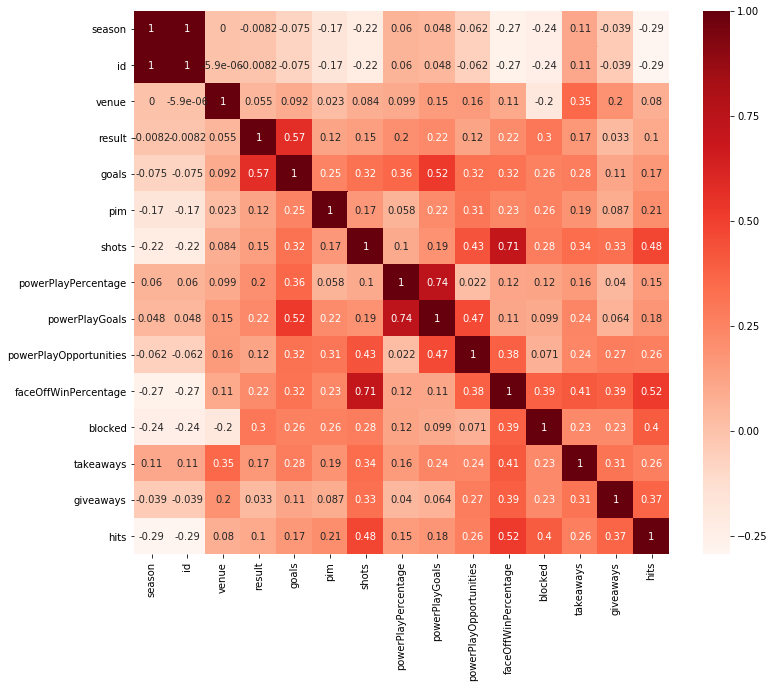

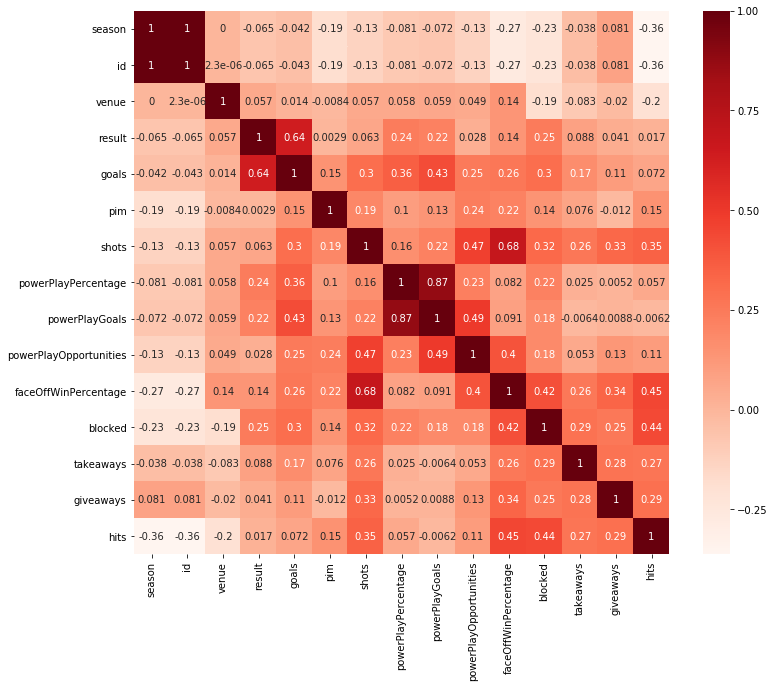

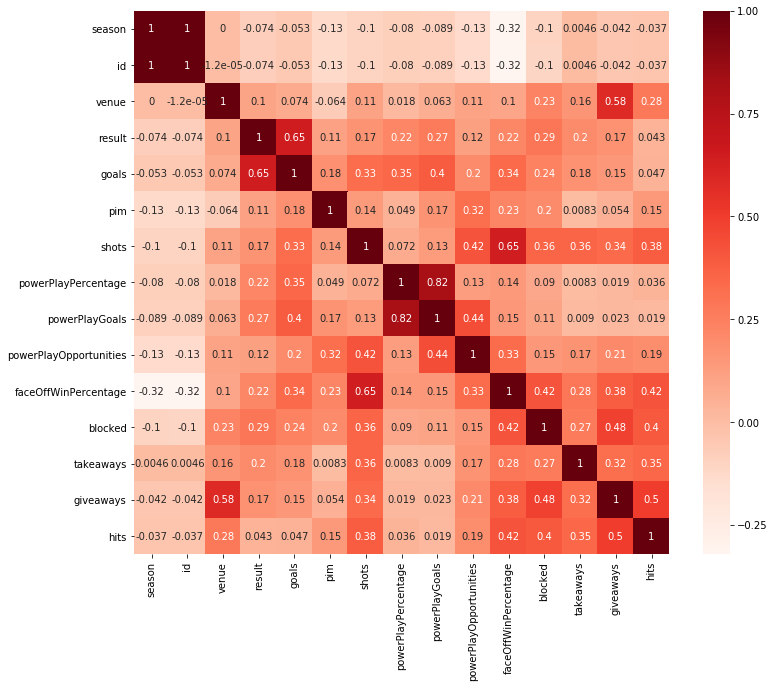

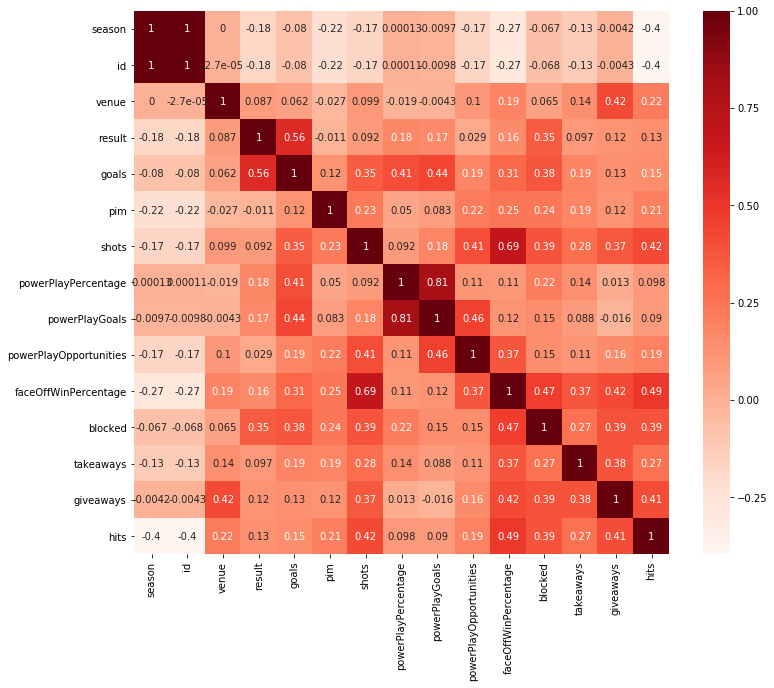

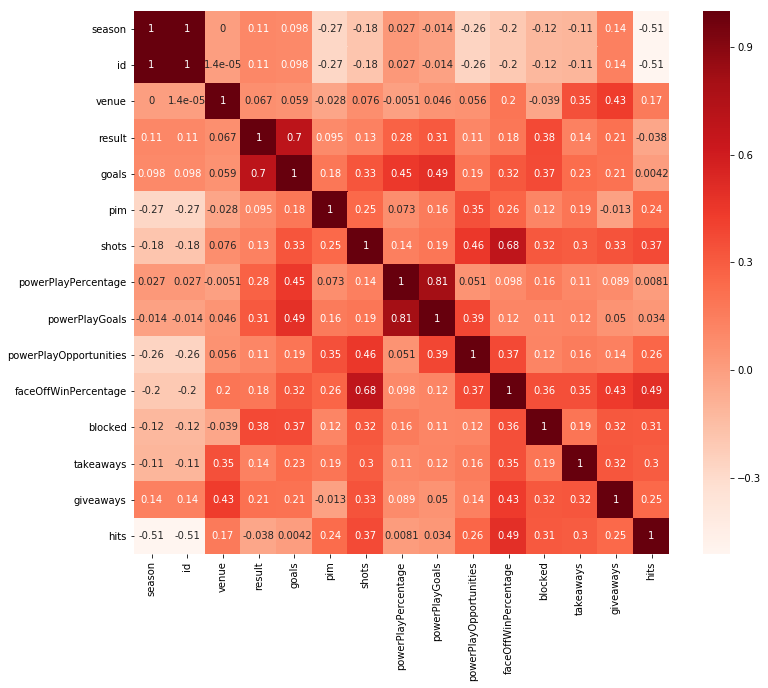

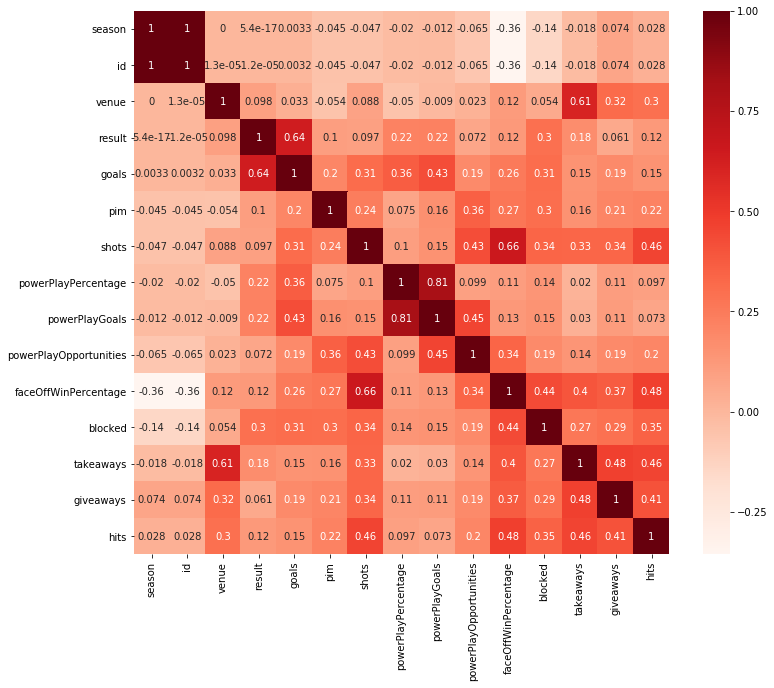

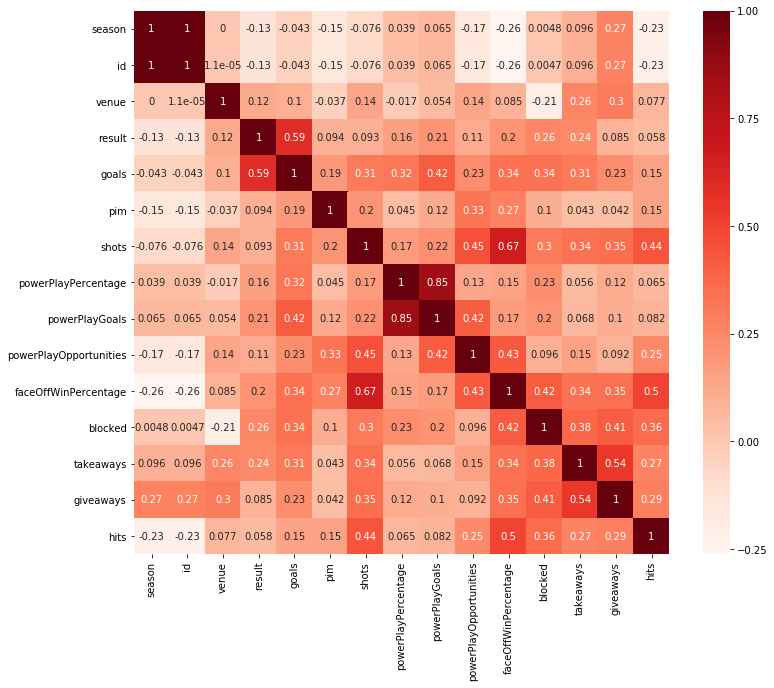

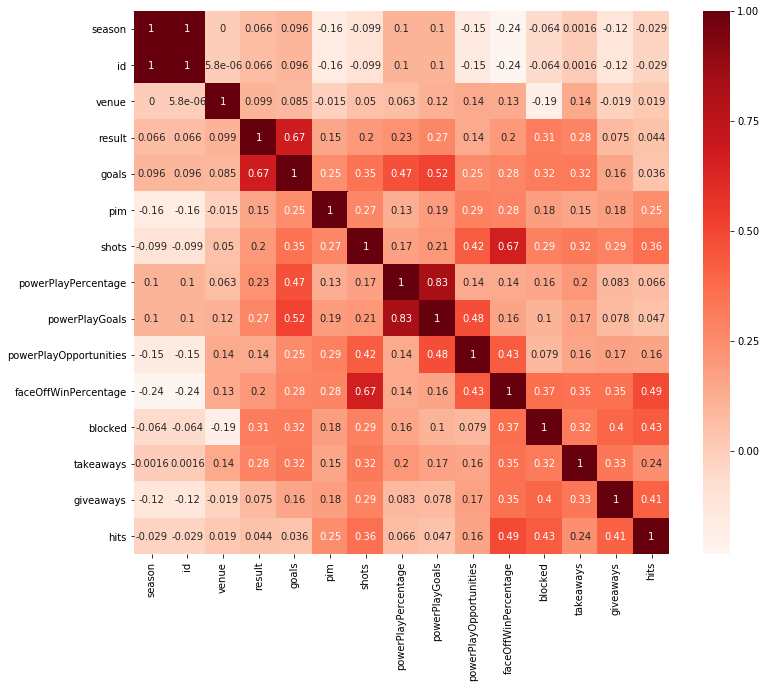

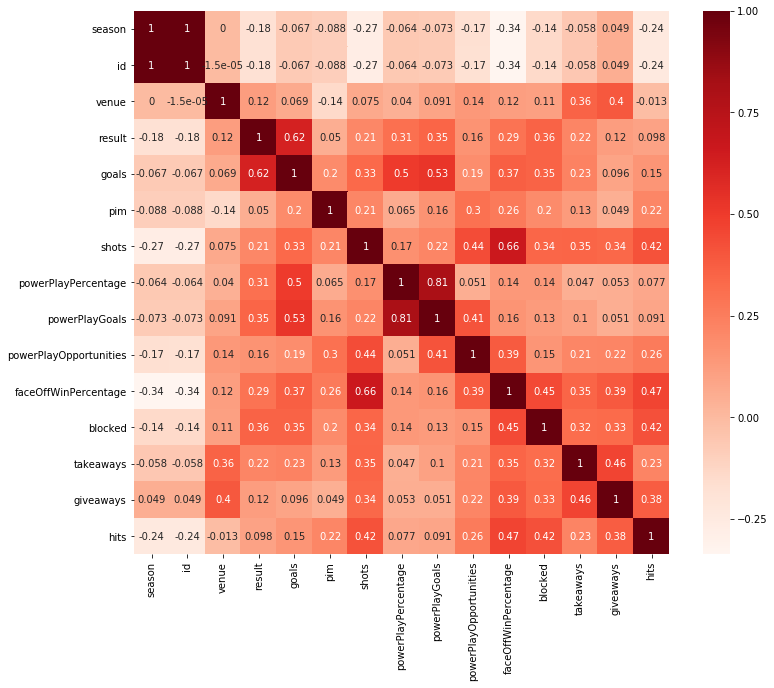

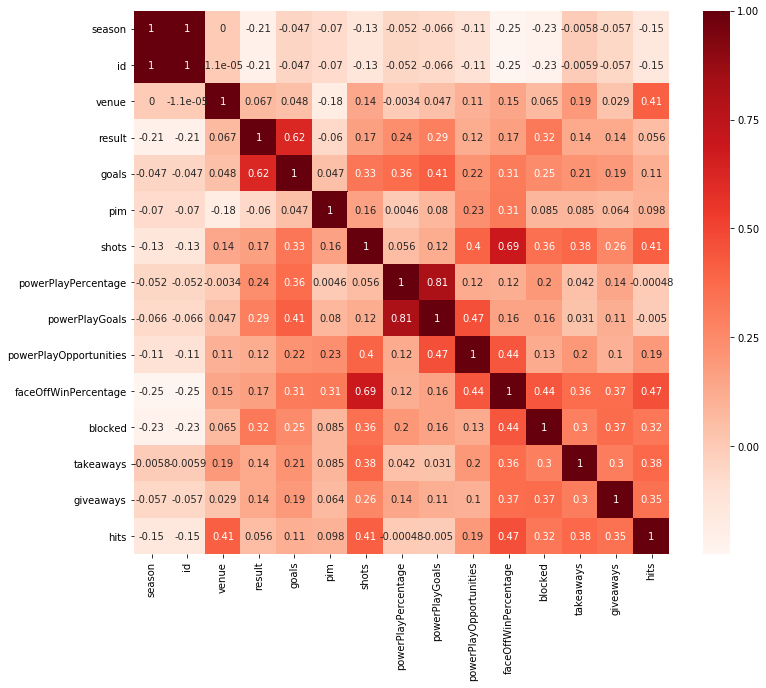

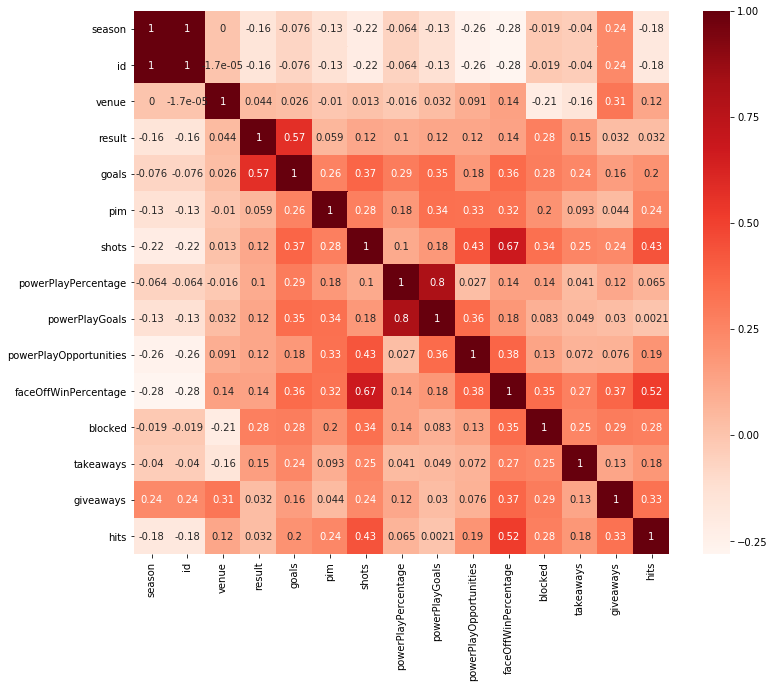

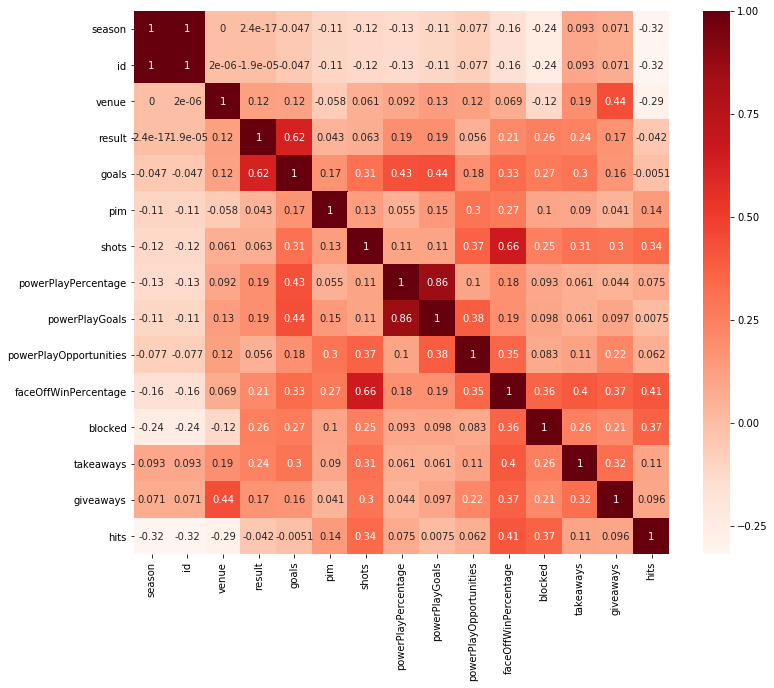

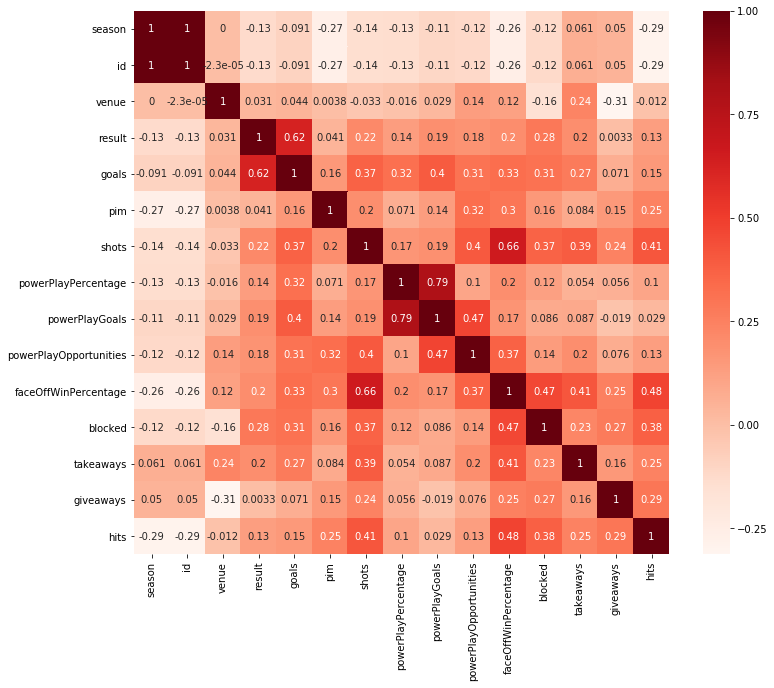

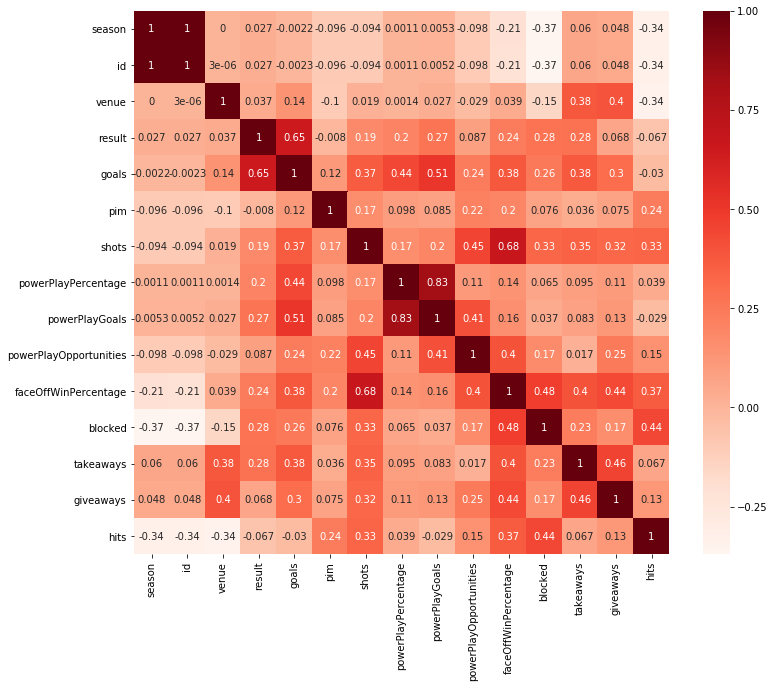

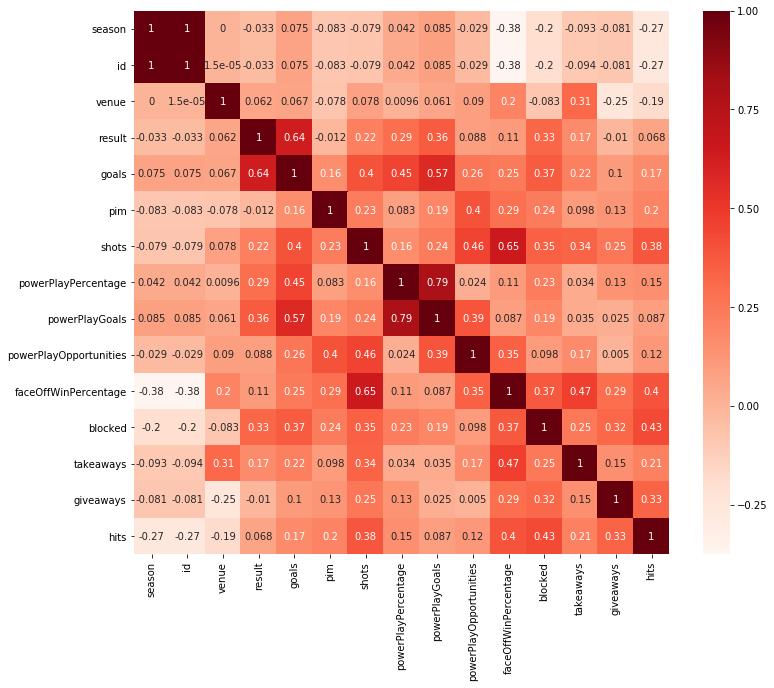

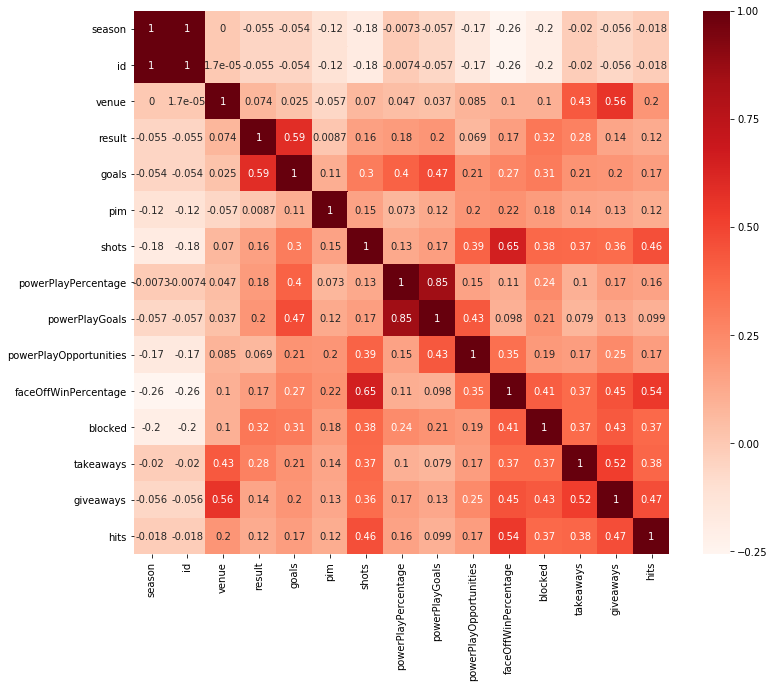

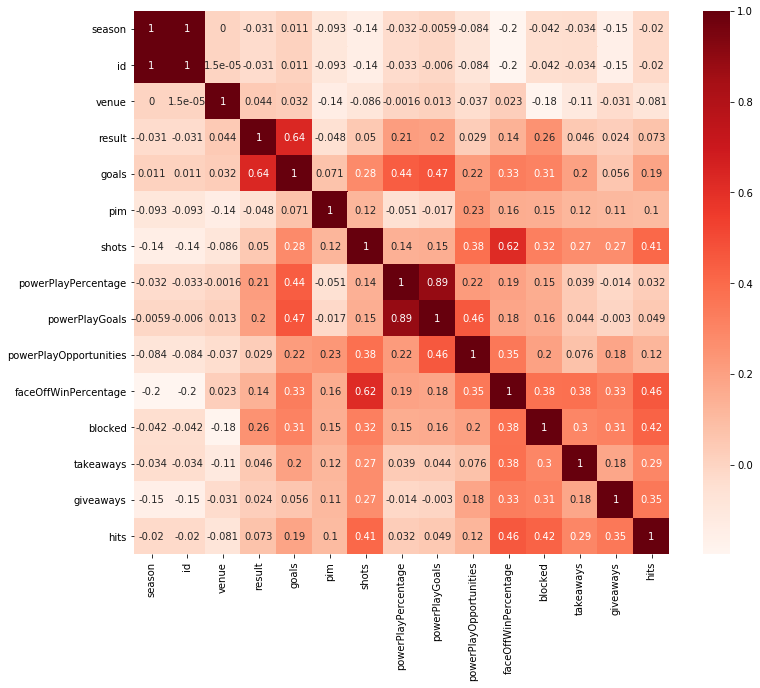

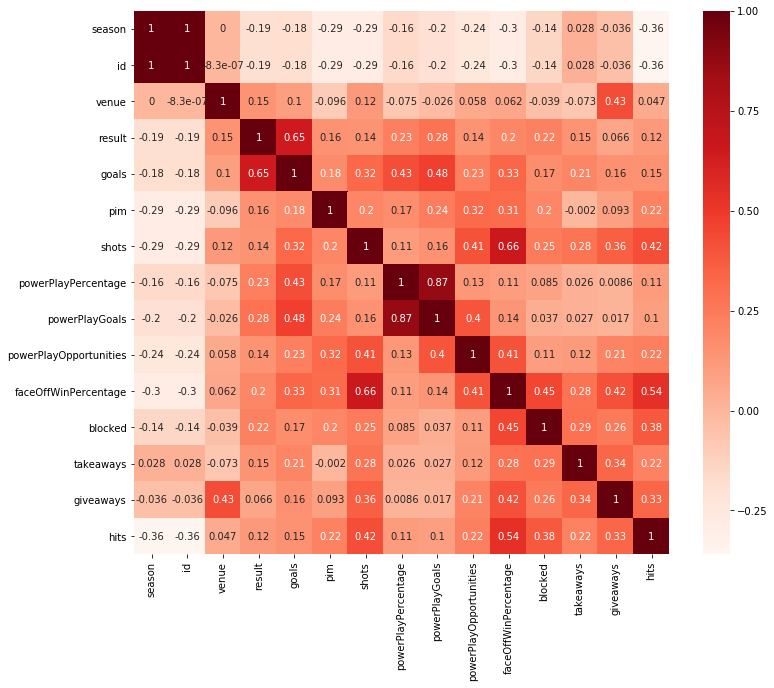

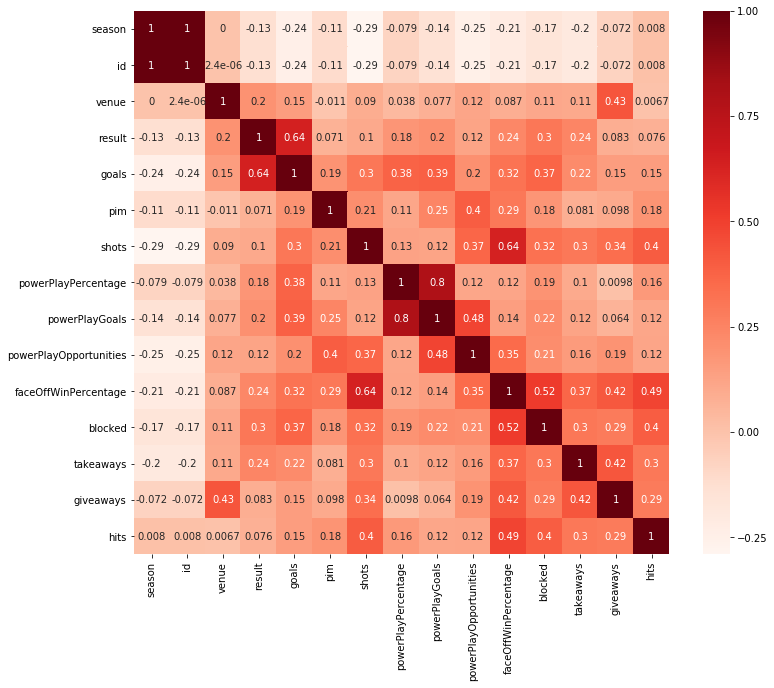

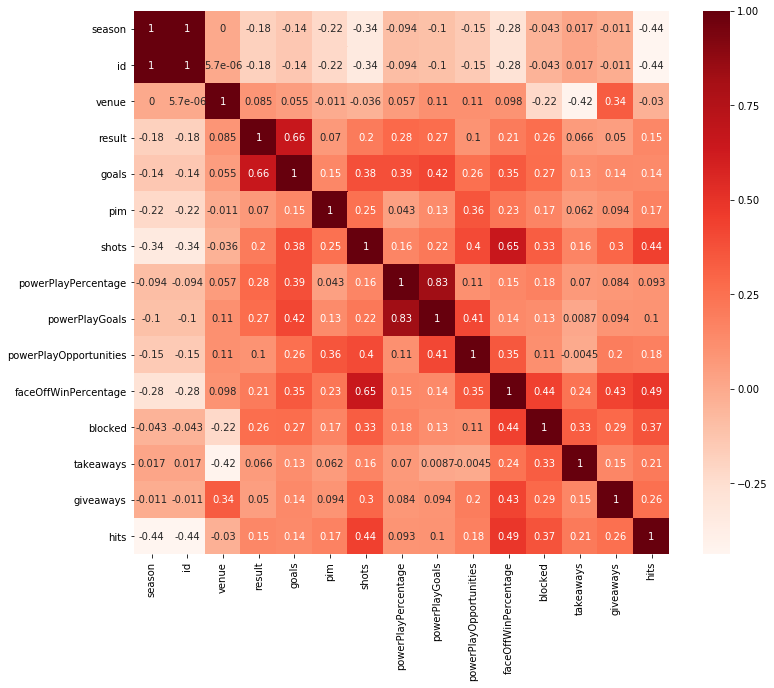

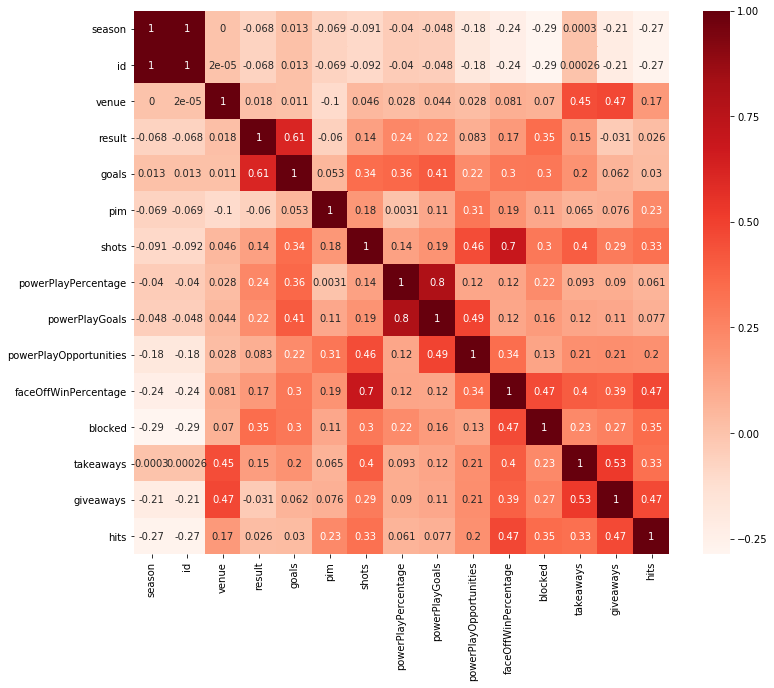

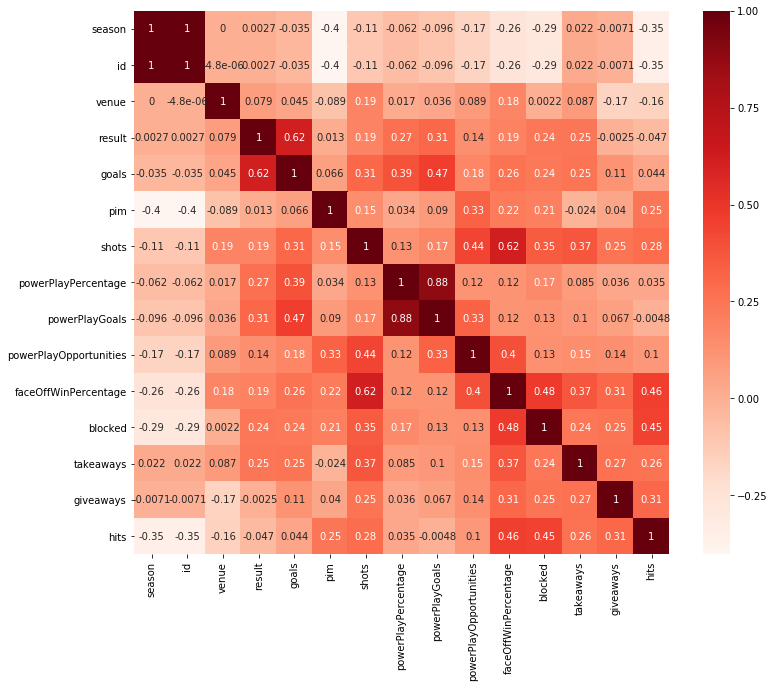

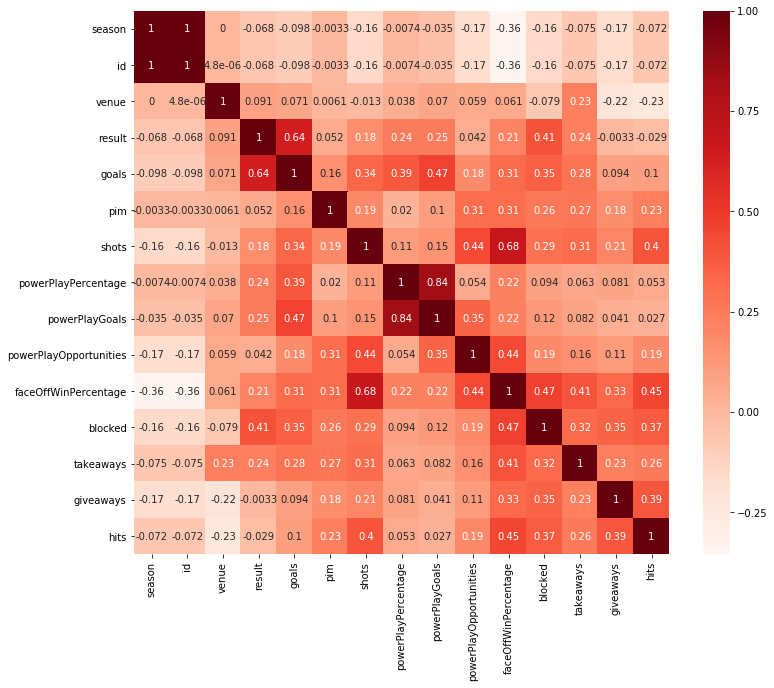

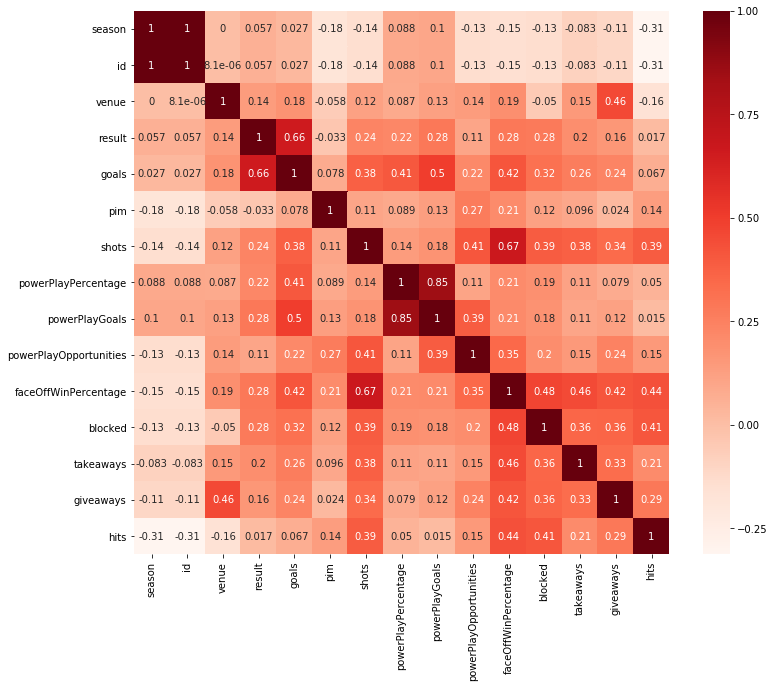

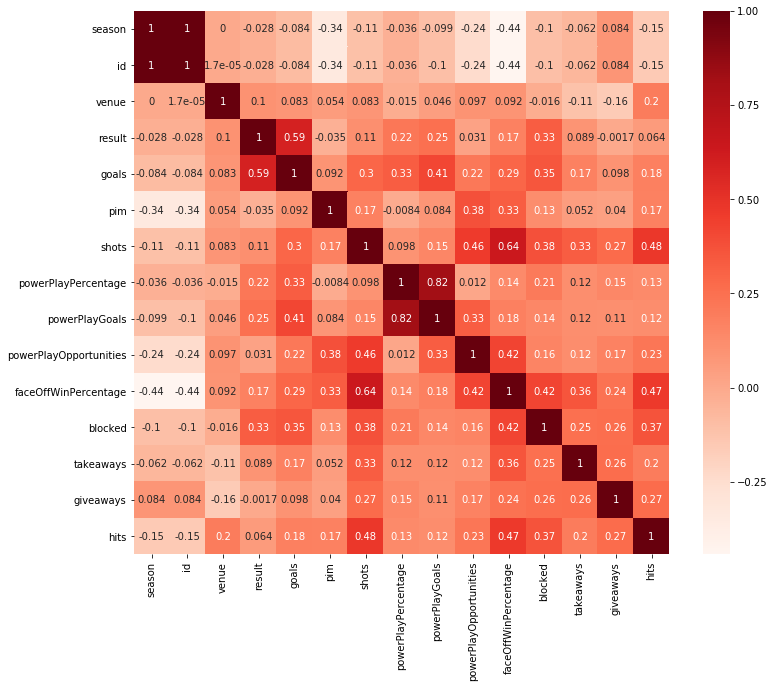

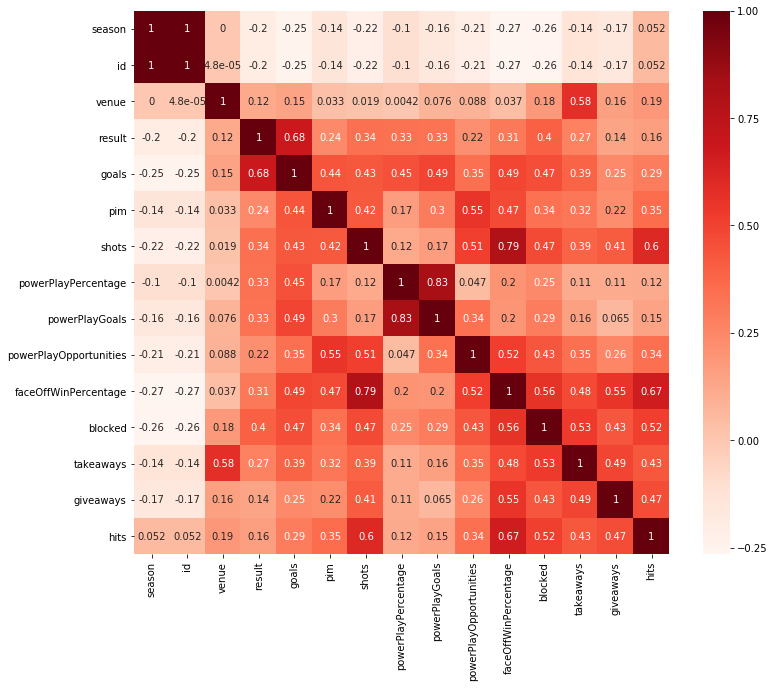

In [13]:
team_names, team_ids = get_teams()

for team in team_names:
    data = pd.read_sql_table(team, conn)
    data.loc[:,'venue'] = data.loc[:,'venue'].map({'home': 1, 'away': 0}) #integer encode venue 
    data.loc[:,'result'] = data.loc[:,'result'].map({'win': 1, 'loss': 0}) #map to binary for classification 
    plt.figure(figsize=(12,10))
    corr = data.corr()
    sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
    plt.show()
#data.head()

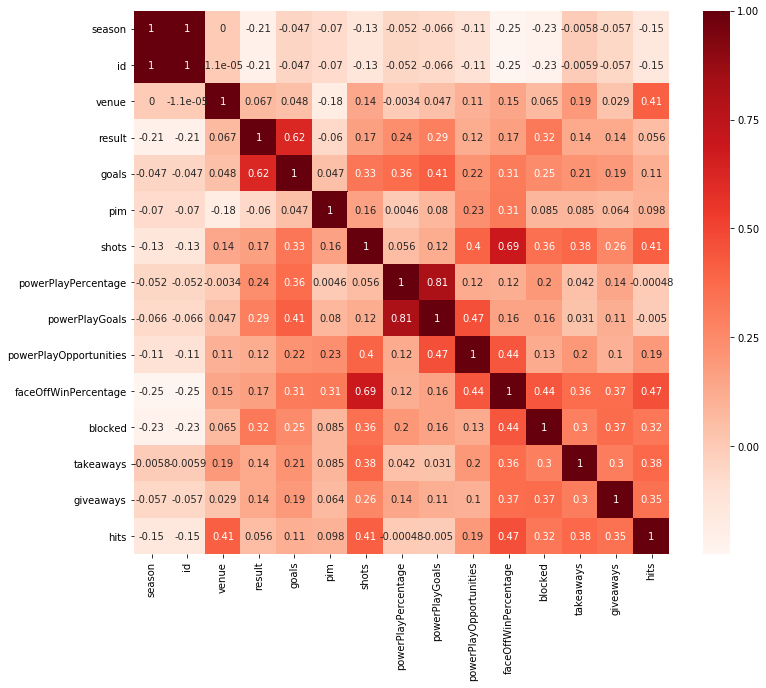

In [11]:
plt.figure(figsize=(12,10))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [9]:
def predict_season_wins(team, conn): 
    """ Function to predict season wins of a NHL team 
    :param conn: Connection object 
    :param team: team name of interest 
    :return accuracy: accuracy of prediction """ 
    data = pd.read_sql_table(team, conn) 
    
    # Get X and y. We're using all of the boxscore stats as features for our model 
    feature_cols = ['season', 'venue', 'goals', 'powerPlayPercentage', 'powerPlayGoals', 'powerPlayOpportunities', 'faceOffWinPercentage', 'shots', 'blocked', 'takeaways', 'giveaways', 'hits'] 
    
    X = data[feature_cols] 
    X.loc[:,'venue'] = X.loc[:,'venue'].map({'home': 1, 'away': 0}) #integer encode venue 
    y = data.loc[:,['result', 'season', 'shots']] #include shots to keep track of current games played 
    y.loc[:,'result'] = y.loc[:,'result'].map({'win': 1, 'loss': 0}) #map to binary for classification 
    
    # Split into test and train data. Use 3 previous seasons for training data (2015/2016, 2016/2017, 2017/2018). 
    # Use current season as test data. 
    X_train, X_test = X.loc[X['season'] < 2018], X.loc[(X['season'] == 2018) & (X['shots'] > 0)] 
    X_train, X_test = X_train.drop(columns=['season']), X_test.drop(columns=['season']) 
    
    y_train, y_test = y.loc[y['season'] < 2018], y.loc[(y['season'] == 2018) & (y['shots'] > 0)] 
    y_train, y_test = y_train.drop(columns=['season', 'shots']), y_test.drop(columns=['season', 'shots']) 
    
    # Select best performing model from 10fold cross validation of training set 
    models = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier()] 
    accuracy_results = [] 
    for model in models: 
        kfold = model_selection.KFold(n_splits=10,random_state=0) 
        results = model_selection.cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold) 
        accuracy_results.append(results.mean()) 
        
    model = models[accuracy_results.index(max(accuracy_results))] 
    model.fit(X_train, y_train.values.ravel()) 
    
    y_pred = model.predict(X_test) 
    res = metrics.accuracy_score(y_test, y_pred) 
    print(type(model).__name__, 'Accuracy on', team, 'test set: {:.3f}'.format(res)) 
    
    return res

In [10]:
team_names, team_ids = get_teams()

In [11]:
res = []
for team in team_names:
    res.append(predict_season_wins(team, conn))

LogisticRegression Accuracy on New Jersey Devils test set: 0.758
LogisticRegression Accuracy on New York Islanders test set: 0.844
LogisticRegression Accuracy on New York Rangers test set: 0.703
LogisticRegression Accuracy on Philadelphia Flyers test set: 0.846
LogisticRegression Accuracy on Pittsburgh Penguins test set: 0.708
LogisticRegression Accuracy on Boston Bruins test set: 0.738
LogisticRegression Accuracy on Buffalo Sabres test set: 0.800
LogisticRegression Accuracy on Montréal Canadiens test set: 0.818
LogisticRegression Accuracy on Ottawa Senators test set: 0.662
LogisticRegression Accuracy on Toronto Maple Leafs test set: 0.877
LogisticRegression Accuracy on Carolina Hurricanes test set: 0.862
LogisticRegression Accuracy on Florida Panthers test set: 0.672
LogisticRegression Accuracy on Tampa Bay Lightning test set: 0.833
LogisticRegression Accuracy on Washington Capitals test set: 0.815
LogisticRegression Accuracy on Chicago Blackhawks test set: 0.662
LogisticRegression Ac

In [12]:
print('Accuracy: {:.3f} ({:.3f})'.format(np.mean(res), np.std(res)))

Accuracy: 0.782 (0.065)
